## Imporitng Libraries and Datasets 

In [93]:
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
#Manufacturing cost per unit
man_costs = pd.read_excel("data/variable costs.xlsx", index_col=0)
man_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


In [3]:
#Freight cost per unit
freight_costs = pd.read_excel("data/freight costs.xlsx", index_col=0)
freight_costs = freight_costs
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


In [4]:
#Total variable cost per unit
var_costs = man_costs+freight_costs/1000
var_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


In [5]:
#Total fixed cost per unit
fixed_costs = pd.read_excel("data/fixed cost.xlsx", index_col=0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


In [6]:
#Plant capacities
capacities = pd.read_excel("data/capacity.xlsx", index_col=0)
capacities

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


In [7]:
#Market demands
demands = pd.read_excel("data/demand.xlsx", index_col=0)
demands

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


## Model Definition and Solving 

In [178]:
locations = ["USA", "GERMANY", "JAPAN", "BRAZIL", "INDIA"]
sizes = ["LOW", "HIGH"]

#Model Definition
model = LpProblem("Production plant location & supply optimization", LpMinimize)

#Inidces
plant_to_size = [(i,s) for s in sizes for i in locations]
plant_to_plant = [(i,j) for i in locations for j in locations]

#Decision Variables
x = LpVariable.dicts("plant_open", plant_to_size, cat = "Binary")
y = LpVariable.dicts("units_supplied", plant_to_plant,  lowBound=0, upBound=None, cat="continuous")

#Objective Function
model += (lpSum([x[(i,s)]*fixed_costs.loc[i,s]*1000 for s in sizes for i in locations]) + 
          lpSum([y[(i,j)]*var_costs.loc[i,j] for i in locations for j in locations]))

#Constraints
for j in locations:
    model += lpSum([y[(i,j)] for i in locations]) == demands.loc[j,"Demand"]
    
for i in locations:
    model += lpSum([y[(i,j)] for j in locations]) <= lpSum([capacities.loc[i,s]*x[(i,s)]*1000 for s in sizes])
    
model.solve()
print(LpStatus[model.status])

x_df = pd.DataFrame(data=[x[plant_to_size[i]].varValue for i in range (len(plant_to_size))], index=[i + "_" + s for s in sizes for i in locations], columns=["Plant Opening"])
y_df = pd.DataFrame(data=[y[(plant_to_plant[i])].varValue for i in range(len(plant_to_plant))], index = [i + "_" + j for i in locations for j in locations], columns = ["Amount Supplied"])

Optimal


## Optimal Solutions 

In [179]:
print(f"Optimal Cost: ${int(value(model.objective))}")

Optimal Cost: $65118000


In [180]:
x_df

,Plant Opening
USA_LOW,0.0
GERMANY_LOW,0.0
JAPAN_LOW,0.0
BRAZIL_LOW,0.0
INDIA_LOW,1.0
USA_HIGH,0.0
GERMANY_HIGH,0.0
JAPAN_HIGH,1.0
BRAZIL_HIGH,1.0
INDIA_HIGH,1.0


## Defining the Optimization Model Function

In [184]:
def optimize(var_costs, fixed_costs, demand_df, demand_col, capacities):
    locations = ["USA", "GERMANY", "JAPAN", "BRAZIL", "INDIA"]
    sizes = ["LOW", "HIGH"]
    location_to_location = [(i,j) for i in locations for j in locations] 
    location_to_size = [(i,s) for s in sizes for i in locations]
    model = LpProblem("Optimize_location_and_supply", LpMinimize)
    x = LpVariable.dicts("plant_opening", location_to_size, cat="Binary")
    y = LpVariable.dicts("units_supplied", location_to_location, lowBound=0, upBound=None, cat="Continuous")
    
    model += (lpSum([fixed_costs.loc[i,s]*x[(i,s)]*1000 for s in sizes for i in locations])+
             lpSum([var_costs.loc[i,j]*y[(i,j)] for i in locations for j in locations]))
    
    for j in locations:
        model += lpSum([y[(i,j)] for i in locations]) == demand_df.loc[j, demand_col]
    for i in locations:
        model += lpSum([y[(i,j)] for j in locations]) <= lpSum([capacities.loc[i,s]*x[(i,s)]*1000 for s in sizes])
    
    model.solve()
    
    status = LpStatus[model.status]
    objective_value = int(pulp.value(model.objective))
    df_plant_opening = pd.DataFrame(data=[x[(i,s)].varValue for s in sizes for i in locations], index = [i + "_" + s for s in sizes for i in locations], columns = ["Open"])
    
    return status, objective_value, df_plant_opening

## Generating Scenarios 

In [185]:
locations = ["USA", "GERMANY", "JAPAN", "BRAZIL", "INDIA"]
demand_df = defaultdict(list)

for location in locations:
    mean = demands.loc[location, "Demand"]
    coeff_variation = 0.5
    demand_array = np.random.normal(mean, coeff_variation*mean,49)//1
    demand_array = [d if d>=0 else 0 for d in demand_array]
    demand_df[location] = demand_array
    
demand_df = pd.DataFrame(demand_df)
demand_df.T

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
USA,4153009.0,788528.0,2896061.0,3419449.0,2327461.0,3776472.0,4420217.0,1509495.0,2878446.0,1364426.0,...,2301911.0,3974394.0,2340405.0,1493714.0,3119461.0,1452638.0,1330518.0,2024081.0,1347425.0,3153197.0
GERMANY,78378.0,57430.0,90336.0,135911.0,29250.0,171941.0,17427.0,132784.0,126223.0,76121.0,...,186670.0,97769.0,31086.0,184962.0,9834.0,107431.0,78056.0,159883.0,122465.0,116994.0
JAPAN,1098674.0,1722260.0,2133517.0,1253572.0,1707886.0,0.0,2876653.0,899215.0,2284413.0,1609259.0,...,2154188.0,860913.0,805992.0,1259276.0,2331298.0,1792836.0,3164817.0,1591144.0,2011230.0,1466506.0
BRAZIL,97627.0,120388.0,203458.0,0.0,185974.0,99734.0,240961.0,294262.0,200609.0,183348.0,...,155510.0,181796.0,182351.0,148487.0,158423.0,116890.0,97300.0,231633.0,254791.0,195116.0
INDIA,150306.0,117085.0,313825.0,108988.0,195080.0,318300.0,77509.0,139675.0,301196.0,178368.0,...,229281.0,157835.0,233390.0,126038.0,260826.0,271620.0,75980.0,186833.0,89113.0,309269.0


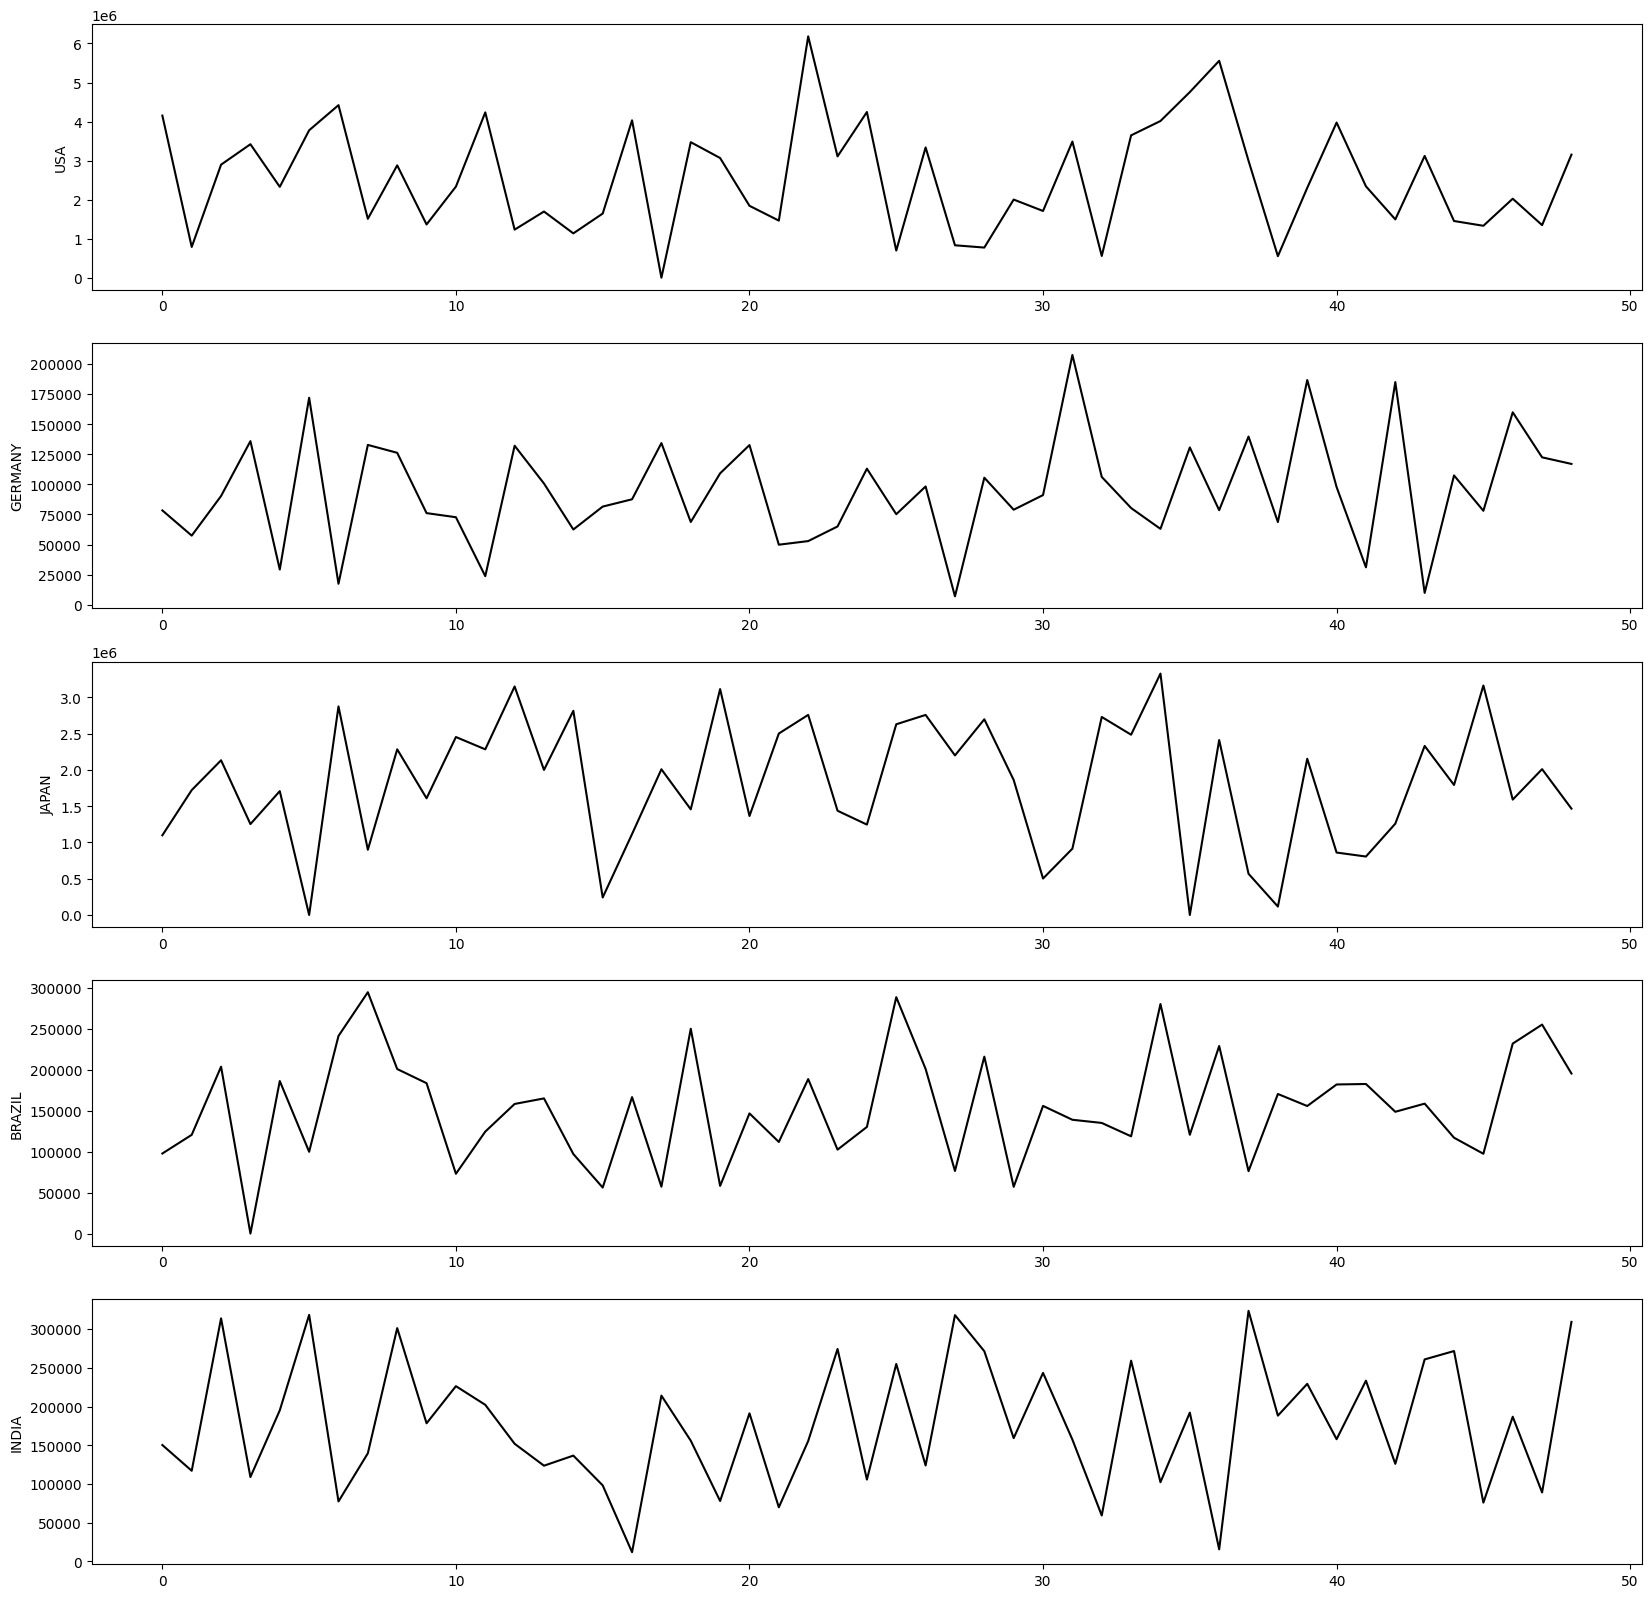

In [186]:
figure, axs = plt.subplots(5,1, figsize=(20,20))

for location in locations:
    sns.lineplot(data=demand_df, x=np.arange(0,49,1), y=location, legend=True, ax=axs[locations.index(location)], color="black")

In [190]:
statuses = []
objective_values = []

status, objective_value, plant_openings = optimize(var_costs, fixed_costs, demands, "Demand", capacities)

for i in range(0,49):
    status, objective_value, df_plant_opening = optimize(var_costs, fixed_costs, demand_df.T, i, capacities)
    statuses.append(status)
    objective_values.append(objective_value)
    plant_openings = pd.concat([plant_openings, df_plant_opening], axis=1)

In [199]:
plant_openings.columns = np.arange(1,51,1)
plant_openings = plant_openings.astype(int)
plant_openings

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
USA_LOW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GERMANY_LOW,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JAPAN_LOW,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
BRAZIL_LOW,0,1,0,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,0,1,1
INDIA_LOW,1,1,0,1,1,0,1,1,0,1,...,1,1,1,1,1,1,1,0,1,1
USA_HIGH,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
GERMANY_HIGH,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
JAPAN_HIGH,1,1,0,1,1,1,0,1,0,1,...,1,1,0,0,1,0,1,1,0,1
BRAZIL_HIGH,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
INDIA_HIGH,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


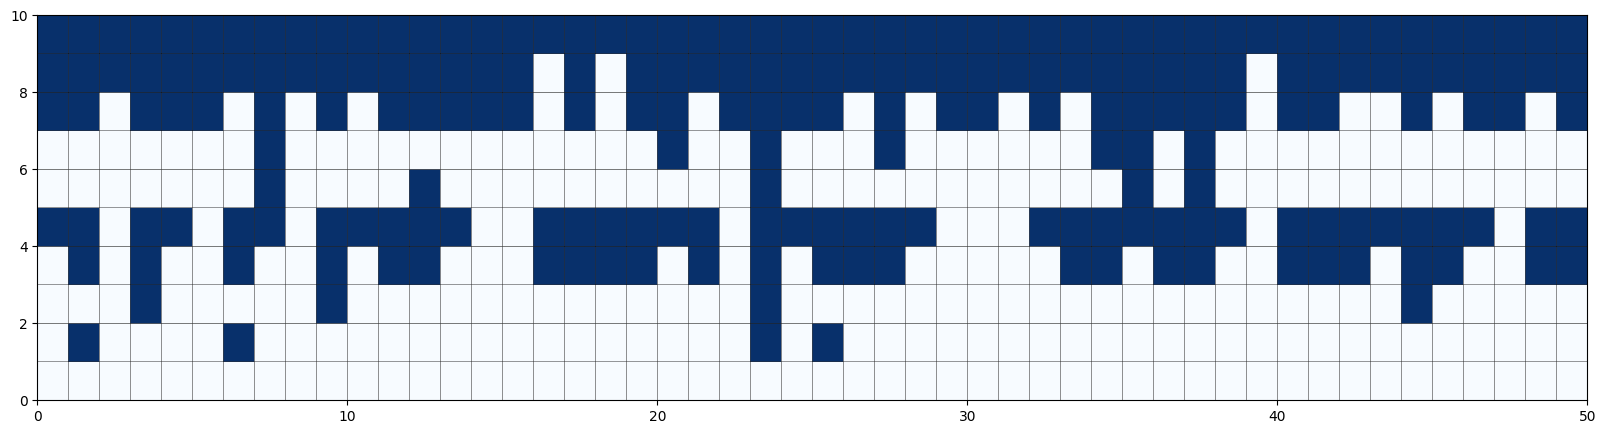

In [208]:
plt.figure(figsize=(20,5))
plt.pcolor(plant_openings, cmap="Blues", edgecolors='k')